In [23]:
import numpy as np
import os

import subprocess
from subprocess import Popen


base_path = '/home/b502b586/ardupilot-workspace/experiments'
os.chdir(base_path)

experiment_path = 'exp-f:700-bw:100-video:1920p-fr:LteFfrSoftAlgorithm-pc:t-sched:FdMt-nbUAVs:1-useCA:false-nbCC:1-scenario:RMa-nbENB:5-run:0'


save_dir = '%s/saved_results' % base_path
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_enabled = True

if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)
os.chdir(experiment_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [3]:
plt.style.use('fivethirtyeight')
# plt.rcParams.update({'font.size': 22, })

In [4]:
def extract_video_throuput(video_0):
    rx_rows = np.where(video_0[:, 1] == 'rx')
    tx_rows = np.where(video_0[:, 1] == 'tx')
    
    rx_info = video_0[rx_rows][:, [0, 2]]
    tx_info = video_0[tx_rows][:, [0, 2]]
    
    rx_sum_rate = 8 * np.array([np.sum(rx_info[np.where(np.array(rx_info[:, 0], dtype=int) == i), 1]) for i in
                                range(int(np.max(rx_info[:, 0])))])
    tx_sum_rate = 8 * np.array([np.sum(tx_info[np.where(np.array(tx_info[:, 0], dtype=int) == i), 1]) for i in
                                range(int(np.max(tx_info[:, 0])))])

    return np.arange(rx_sum_rate.shape[0]), rx_sum_rate / (2 ** 20), np.arange(tx_sum_rate.shape[0]), tx_sum_rate / (2 ** 20)

def smooth(rx_sum_rate):
    window_size = 15

    rx_data = pd.Series(rx_sum_rate)
    windows = rx_data.rolling(window_size)
    rx_sum_rate = windows.mean()
    
    return np.arange(rx_sum_rate.shape[0]), rx_sum_rate

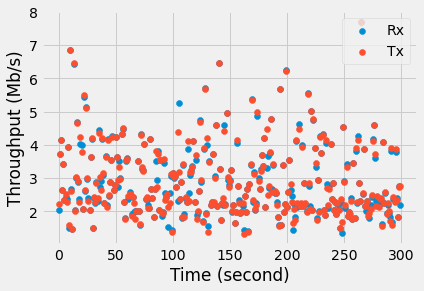

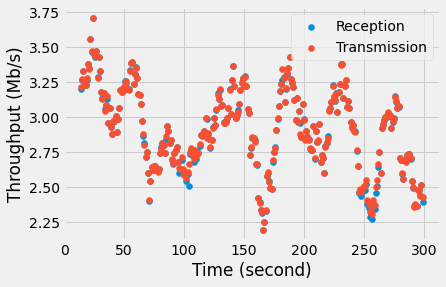

In [27]:
video_0 = pd.read_csv('./uav-1-VideoPacketTrace.txt', delimiter='\t').to_numpy()

rx_t, rx_sum_rate, tx_t, tx_sum_rate = extract_video_throuput(video_0)  # 6 mhz

plt.figure()

plt.scatter(np.arange(rx_sum_rate.shape[0]), rx_sum_rate, label='Rx')
plt.scatter(np.arange(tx_sum_rate.shape[0]), tx_sum_rate, label='Tx')

plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('Throughput (Mb/s)')
plt.show()


smoothed_rx_t, smoothed_rx_sum_rate = smooth(rx_sum_rate)
smoothed_tx_t, smoothed_tx_sum_rate = smooth(tx_sum_rate)

plt.figure()
plt.scatter(smoothed_rx_t, smoothed_rx_sum_rate, label='Reception')
plt.scatter(smoothed_tx_t, smoothed_tx_sum_rate, label='Transmission')

plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('Throughput (Mb/s)')
plt.show()

In [6]:
def extract_loc_data(mob_0):
    node_0_data = mob_0[np.argwhere(mob_0[:, 1] == 0)[:, 0]]
    node_0_loc = np.array([r.split(':') for r in node_0_data[:, 2]], dtype=float)
    node_0_t = node_0_data[:, 0]
    return node_0_t, node_0_loc

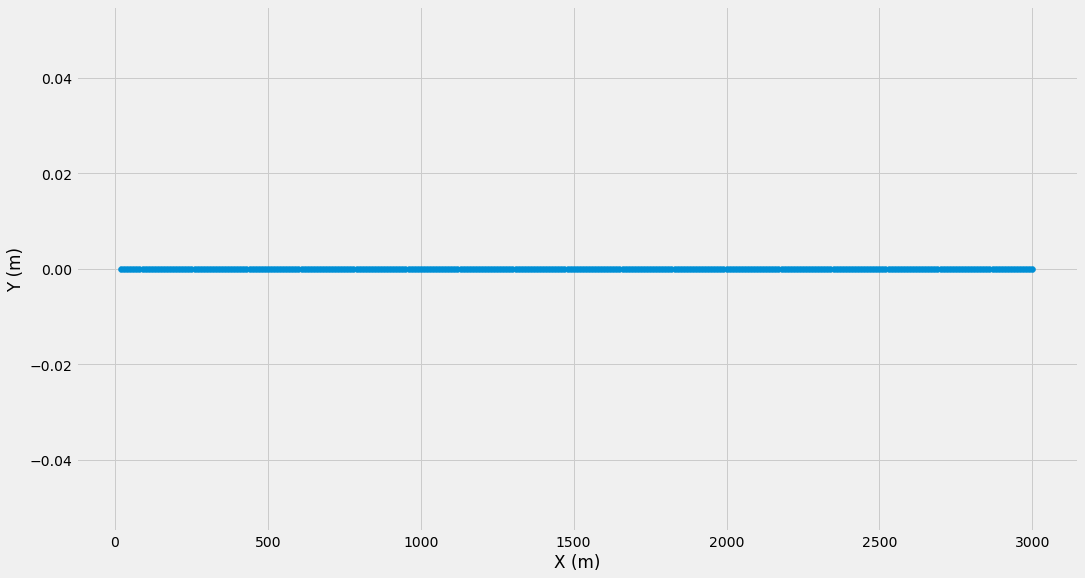

In [25]:
mob_0 = pd.read_csv('./mobility-trace-example.mob', delimiter=',').to_numpy()

enb_loc = np.array([[0,-100,35], [1732,100,35], [3464,-100,35], [5196,100,35], [6928,-100,35]])

node_0_t, node_0_loc = extract_loc_data(mob_0)

plt.figure(figsize=(16, 9))
plt.scatter(node_0_loc[:, 0], node_0_loc[:, 1])
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.savefig('%s/Trajectory.pdf' % save_dir)
plt.show()

In [8]:
def get_distanc(node_0_loc):
    diff = np.subtract(node_0_loc, node_0_loc[0])
    diff2D = diff[:, :2] ** 2
    diff2D = np.sum(diff2D, axis=1)
    diff2D = np.sqrt(diff2D)
    return diff2D



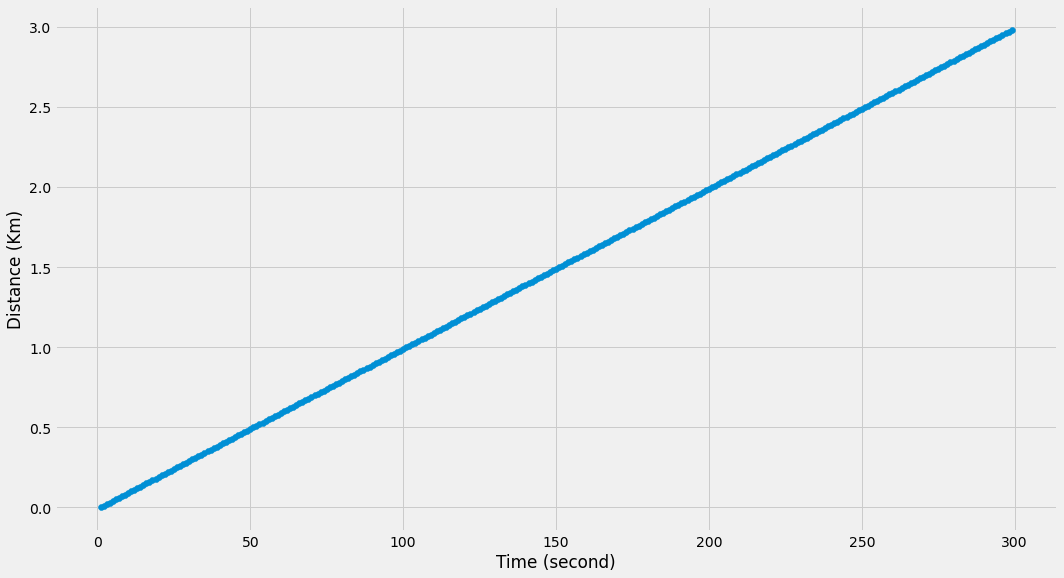

In [26]:
diff2d = get_distanc(node_0_loc)

plt.figure(figsize=(16, 9))
plt.scatter(node_0_t / 1000, diff2d/1000)
plt.xlabel('Time (second)')
plt.ylabel('Distance (Km)')
plt.savefig('%s/Distance.pdf' % save_dir)
plt.show()

In [10]:
def extract_dl_info(rma2000):
    t = rma2000[:, 0]
    rsrp = 10 * np.log10(rma2000[:, 4])
    sinr = 10 * np.log10(rma2000[:, 5])
    return t, rsrp, sinr


def extract_ul_sinr(rma2000):
    t = rma2000[:, 0]
    sinr = 10 * np.log10(rma2000[:, 4])
    return t, sinr

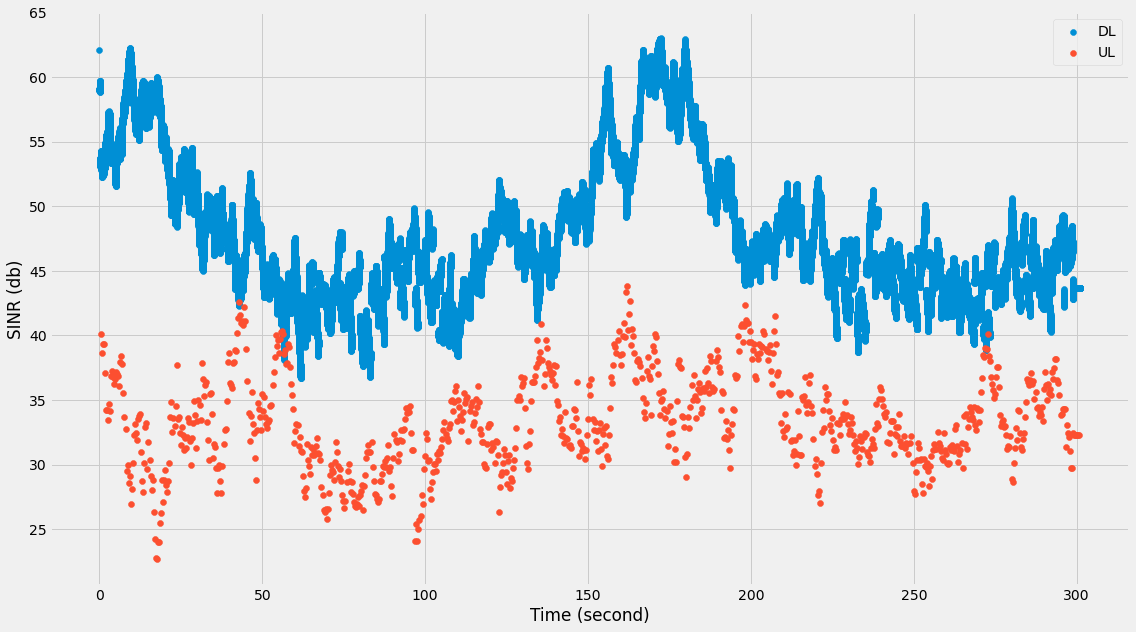

In [28]:
dl_0 = pd.read_csv('./DlRsrpSinrStats.txt', delimiter='	').to_numpy()
ul_0 = pd.read_csv('./UlSinrStats.txt', delimiter='	').to_numpy()

dl_t, dl_rsrp, dl_sinr = extract_dl_info(dl_0)

ul_t, ul_sinr = extract_ul_sinr(ul_0)


########################### plot Down Link Stats ##############################
plt.figure(figsize=(16, 9))

plt.scatter(dl_t, dl_sinr, label='DL')
plt.scatter(ul_t, ul_sinr, label='UL')

plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('SINR (db)')
plt.tight_layout()

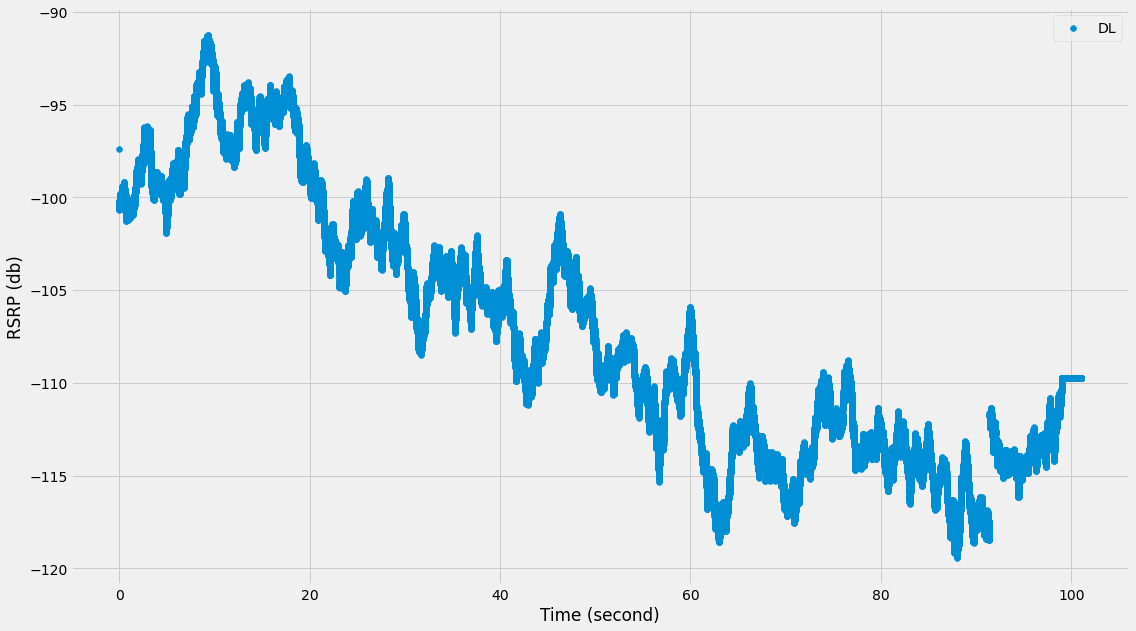

In [21]:
plt.figure(figsize=(16, 9))

plt.scatter(dl_t, dl_rsrp, label='DL')

plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('RSRP (db)')
plt.tight_layout()

In [15]:
# os.chdir(experiment_path)

def extract_delay_data(telemetry_data):
    node_0_data = telemetry_data[np.argwhere(np.array(telemetry_data[:, 1], dtype=int) == 1)[:, 0]]
    node_0_delay = node_0_data[:, 4]
    node_0_t = node_0_data[:, 0]
    return node_0_t, node_0_delay

In [14]:
telemetry_data = pd.read_csv('./uav-1-telemetry-info.txt', delimiter=',').to_numpy()

t, delay = extract_delay_data(telemetry_data)

plt.figure(figsize=(16, 9))

plt.scatter(t, delay, label='Telemetry Delay')

plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('Delay (ms)')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './uav-1-telemetry-info.txt'